In [1]:
import numpy as np
import scipy as sp
from scipy import io,integrate,sparse
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import math 

from spec_bin import *
#from lanczos_bin import mystep,distribution

from IPython.display import clear_output
np.set_printoptions(linewidth=300)
%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams['text.latex.preamble'] = r'\renewcommand{\vec}{\mathbf}'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [3]:
def mu_T(x,a,b): 
    with np.errstate(divide='ignore',invalid='ignore'):
        return 1/(np.pi)/(np.sqrt((x-a)*(b-x)))

In [4]:

kn=23
kk=11

λ = np.array([(-1)**i*math.comb(kn-kk-i,kk-i) for i in range(kk+1)])
mult = np.array([math.comb(kn,i) - math.comb(kn,i-1) if i>0 else 1 for i in range(kk+1)])

idx = np.argsort(λ)
λ,mult = λ[idx], mult[idx]

A = sp.sparse.load_npz(f'matrices/K_{kn}_{kk}.npz')
n = A.shape[0]
n_trials = 1

np.random.seed(0)

v = np.random.randn(n)
v /= np.linalg.norm(v)

k = 12
(α,β) = lanczos(A,v,k)

a = -kk-.1
b = kk+1.1

kT = 250
sT = 2*kT
αT = np.ones(sT+1)*(a+b)/2
βT = np.ones(sT+1)*(b-a)/4
βT[0] *= np.sqrt(2)
mT = get_chebyshev_moments(A,v,kT,a,b)


In [5]:
θ,ω = get_gq(k,α[:12],β[:11])
xx = np.linspace(a,b,5000)
AQ_T = eval_poly(xx,mT*jackson_weights(2*kT+1),αT,βT)

In [6]:
s=30
min(get_iq(mT[:s+1]*jackson_weights(s+1),s,αT,βT)[1])

1.0808276417615966e-05

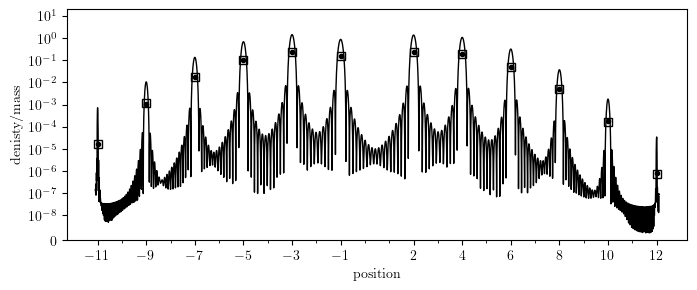

In [7]:
plt.subplots(1,1,figsize=(8,3))

plt.plot(xx,AQ_T*mu_T(xx,a,b),lw=1,color='k')

plt.plot(θ,ω,ls='None',marker='o',ms=3,color='k')
plt.plot(λ,mult/sum(mult),ls='None',marker='s',fillstyle='none',color='k')


plt.gca().set_xticks(np.arange(int(a),round(b)+1), minor=True)
plt.xticks(λ)

plt.xlabel('position')
plt.ylabel('denisty/mass')


plt.ylim(0,20)
plt.yscale('symlog',linthresh=1e-8)
plt.savefig('imgs/Kneser_smoothed.pdf',bbox_inches='tight')

In [8]:
err_gq = np.full(k+1,np.nan)

for ki in range(1,13):
    θ,ω = get_gq(ki,α,β)
    err_gq[ki] = sp.stats.wasserstein_distance(θ,λ,ω,mult/sum(mult))

In [9]:
xx = np.linspace(a,b,5000)

err_dq = np.full(kT+1,np.nan)

xx = np.linspace(a,b,5000)[1:-1]

ks = np.geomspace(1,kT,40,dtype='int')
for ki in ks:
    AQ_T = eval_poly(xx,mT[:2*ki+1]*jackson_weights(2*ki+1),αT,βT)
    μAQ = AQ_T*mu_T(xx,a,b)
    err_dq[ki] = sp.stats.wasserstein_distance(xx,λ,μAQ,mult/sum(mult))

/tmp/ipykernel_2736660/204062292.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.plot(np.arange(kT),2e1/np.arange(kT),ls=':',lw=1,color='k')


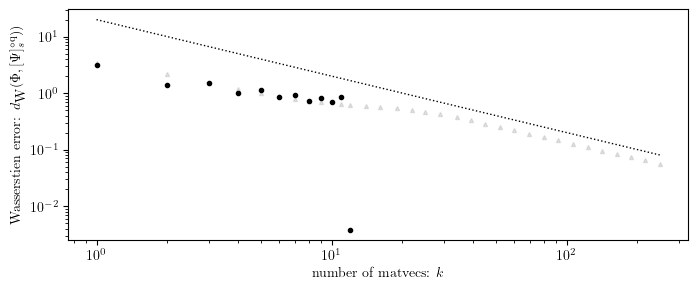

In [10]:
fig,axs = plt.subplots(1,1,figsize=(8,3),sharey=True)


plt.plot(err_gq,label='GQ',marker='o',ms=3,ls='None',color='k')
plt.plot(err_dq,label='DAQ',marker='^',alpha=.1,ms=3,ls='None',color='k')
plt.plot(np.arange(kT),2e1/np.arange(kT),ls=':',lw=1,color='k')

plt.yscale('log')
plt.xscale('log')

plt.ylabel(r'Wasserstien error: $d_{\textup{W}}(\Phi,[\Psi]_s^{\circ\mathrm{q}}))$')
plt.xlabel('number of matvecs: $k$')

plt.savefig('imgs/Kneser_smoothed_convergence.pdf',bbox_inches='tight')